In [1]:
import cv2
import numpy as np 
import os
from random import shuffle
from  tqdm import tqdm

In [2]:
#Precise Train and Test directories
Train_dir = 'train'
Test_dir = 'test'
#Precise Image size wheather 28 or 50 
image_Size = 50
#Learning rate : too small you can stuck in a local minimum but fast : too big is quicker but you risk going underfitted
LearningRate = 0.001

In [3]:
ModelName = "CatVsDogs-{}-{}".format(LearningRate, '6convBasic')

In [4]:
#Since it's a supervised learning we keep the label of the images
def label_image(img):
    word_label = img.split('.')[-3]
    if word_label == "cat" :
        return [1,0]
    elif word_label == "dog":
        return [0,1]

In [5]:
#Treating Images to create our own data and storage [image,label]
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(Train_dir)):
        label = label_image(img)
        path = os.path.join(Train_dir, img)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (image_Size,image_Size))
        training_data.append([np.array(img), np.array(label)])
    
    shuffle(training_data)
    np.save('train_data.npy' , training_data)
    return training_data
        

In [6]:
#For the testing we only need number [image,num]
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(Test_dir)):
        #label = label_image(img)
        path = os.path.join(Test_dir, img)
        img_num = img.split('.')[0]
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (image_Size,image_Size))
        testing_data.append([np.array(img), np.array(img_num)])
    
    np.save('test_data.npy' , testing_data)
    return testing_data

In [7]:
#For the first time Create train data and it will be saved as 'train_data.npy'
#train_data = create_train_data()
#if already did you only need to load it
train_data = np.load('train_data.npy')

In [8]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf
tf.reset_default_graph()

#1layer = linear problem 
#2layers =  non-linear problem

convnet = input_data(shape=[None, image_Size, image_Size, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate= LearningRate, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir = 'log')


hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [9]:
#Save progress
if os.path.exists('{}.meta'.format(ModelName)):
    model.load(ModelName)
    print('model loded successfully')

INFO:tensorflow:Restoring parameters from D:\python\CatDogClassification\CatVsDogs-0.001-6convBasic
model loded successfully


In [10]:
#Split training and Testing Data :
train = train_data[:-500]
test = train_data[-500:]

In [11]:
#Prepare our inputs : image must be reshaped (-1,50,50,1)
X = np.array([i[0] for i in train]).reshape(-1, image_Size, image_Size, 1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1, image_Size, image_Size, 1)
test_y = [i[1] for i in test]

In [12]:
#Calculate our model
model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=ModelName)

Training Step: 3446  | total loss: 0.35970 | time: 68.878s
| Adam | epoch: 003 | loss: 0.35970 - acc: 0.8468 -- iter: 24448/24500
Training Step: 3447  | total loss: 0.36523 | time: 70.060s
| Adam | epoch: 003 | loss: 0.36523 - acc: 0.8433 | val_loss: 0.53451 - val_acc: 0.7640 -- iter: 24500/24500
--


In [13]:
#To see the tensorboard just use this :
#tensorboard --logdir = foo:C:\..\log\

In [14]:
#Save our Model:
model.save(ModelName)

INFO:tensorflow:D:\python\CatDogClassification\CatVsDogs-0.001-6convBasic is not in all_model_checkpoint_paths. Manually adding it.


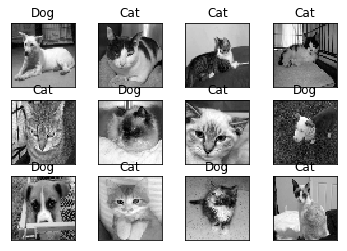

In [22]:
#To test our Model
import matplotlib.pyplot as plt

#test_data= process_test_data()
#if already done 
test_data = np.load('test_data.npy')

fig = plt.figure()
for num, data in enumerate(test_data[8:20]):
    #cat:[1,0]
    #dog:[0,1]
    img_num = data[1]
    img_data= data[0]
    
    y = fig.add_subplot(3,4, num+1)
    orig = img_data
    data = img_data.reshape(image_Size, image_Size, 1)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1:
        str_label='Dog'
    else:
        str_label ='Cat'
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()
    